<a href="https://colab.research.google.com/github/pragyasingh1729/SentimentAnalysis/blob/main/SentimentAnalysis_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries and getting data from Kaggle


In [1]:
!pip install nltk

In [2]:
import os
import json
from zipfile import ZipFile

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

# Lemmatizes words to their base or root form
from nltk.stem import WordNetLemmatizer
# Tokenizes a string into individual words
from nltk.tokenize import word_tokenize
# Tags words in a sentence with their corresponding part-of-speech
from nltk import pos_tag
# wordnet is a lexical database of english. Find synonyms, antonyms, and other semantic relationships between words
from nltk.corpus import wordnet, stopwords

import re, string, unicodedata
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from string import punctuation

import warnings
warnings.filterwarnings('ignore')


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
!pip install kaggle --q

In [5]:
!kaggle datasets download -d crisbam/imdb-dataset-of-65k-movie-reviews-and-translation

Dataset URL: https://www.kaggle.com/datasets/crisbam/imdb-dataset-of-65k-movie-reviews-and-translation
License(s): CC0-1.0
 99% 146M/147M [00:01<00:00, 119MB/s]
100% 147M/147M [00:01<00:00, 107MB/s]


In [6]:
!ls

imdb-dataset-of-65k-movie-reviews-and-translation.zip  sample_data


In [7]:
with ZipFile('imdb-dataset-of-65k-movie-reviews-and-translation.zip', 'r') as zipref:
  zipref.extractall()

In [8]:
!ls

IMDB-Dataset.csv  imdb-dataset-of-65k-movie-reviews-and-translation.zip  sample_data


In [9]:
df = pd.read_csv('IMDB-Dataset.csv')

### Data cleaning and preprocessing

In [10]:
df.head()

,Ratings,Reviews,Movies,Resenhas
0,1.0,*Disclaimer: I only watched this movie as a co...,Disaster Movie,* Isenção de responsabilidade: eu só assisti e...
1,1.0,I am writing this in hopes that this gets put ...,Disaster Movie,Estou escrevendo isso na esperança de que isso...
2,1.0,"Really, I could write a scathing review of thi...",Disaster Movie,"Realmente, eu poderia escrever uma crítica con..."
3,1.0,If you saw the other previous spoof movies by ...,Disaster Movie,Se você viu os outros filmes falsificados ante...
4,1.0,This movie I saw a day early for free and I st...,Disaster Movie,Este filme eu vi um dia cedo de graça e ainda ...


In [11]:
stop_words = stopwords.words('english')

In [12]:
new_stopwords = ["might", "could", "one", "film", "movie", "would", "shall"]
stop_words.extend(new_stopwords)
stop_words.remove("not") # helps in identifying a bad review
stop_words = set(stop_words) # helps in removing copies of the word

In [13]:
contraction_mapping = {
    "won't": "would not",
    "can't": "can not",
    "don't": "do not",
    "shouldn't": "should not",
    "needn't": "need not",
    "hasn't": "has not",
    "haven't": "have not",
    "weren't": "were not",
    "mightn't": "might not",
    "didn't": "did not"

}

content = "I haven't seen him, but I won't be surprised if he comes."

for contraction, expanded_form in contraction_mapping.items():
  content = re.sub(r"\b" + re.escape(contraction) + r"\b", expanded_form, content)

print(content)


I have not seen him, but I would not be surprised if he comes.


In [14]:
def preprocessing_text(text):

  for contraction, expanded_form in contraction_mapping.items():
        text = re.sub(r"\b" + re.escape(contraction) + r"\b", expanded_form, text)

  text = text.lower()

  text = re.sub('<.*?>', ' ', text)
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  text = re.sub('https\S+\s', ' ', text)

  text = nltk.word_tokenize(text)

  text = [word for word in text if word not in stop_words]

  lmtr = WordNetLemmatizer()

  text = [lmtr.lemmatize(word) for word in text]

  return " ".join(text)

In [15]:
df['Clean_Review'] = df['Reviews'].apply(preprocessing_text)

In [16]:
pd.options.display.max_colwidth = 1000
df.head(5)

,Ratings,Reviews,Movies,Resenhas,Clean_Review
0,1.0,"*Disclaimer: I only watched this movie as a conditional agreement. And I see films for free. I wouldn't be caught dead giving my hard earned money to these idiots.Well, to explain the depth of this 'film', I could write my shortest review, ever. Don't see this movie. It is by far the stupidest, lamest, most lazy, and unbelievably UNFUNNY movie I have ever seen. It is a total disaster. But since my hatred for this movie, and the others like it, extends far beyond one viewing, I think I'll go on for a bit.I don't know any of the people in the movie besides Carmen Electra, Vanessa Minnillo, and Kim Kardashian, but it doesn't matter. They're all horrible, though I think that was the point. The editing is flat out horrible, and possibly blatant continuity errors make this crapfast even crappier than I thought it would be. Now I know that these films are not supposed to be serious at all, but come on, it's film-making 101 that if someone gets a minor facial cut, it should be there in the...",Disaster Movie,"* Isenção de responsabilidade: eu só assisti esse filme como um acordo condicional. E eu vejo filmes de graça. Eu não seria pego morto dando meu dinheiro suado a esses idiotas. Bem, para explicar a profundidade desse 'filme', eu poderia escrever minha crítica mais curta de todos os tempos. Não vê este filme. É de longe o filme mais estúpido, lamenta, preguiçoso e inacreditavelmente UNFUNNY que eu já vi. É um desastre total. Mas como o meu ódio por este filme e por outros, se estende muito além de uma exibição, acho que vou continuar um pouco. Não conheço nenhuma das pessoas do filme além de Carmen Electra, Vanessa Minnillo, e Kim Kardashian, mas isso não importa. Eles são todos horríveis, embora eu ache que esse seja o ponto. A edição é horrível e, possivelmente, erros de continuidade flagrantes tornam essa porcaria ainda mais horrível do que eu pensava. Agora eu sei que esses filmes não devem ser sérios, mas vamos lá, é o cinema 101 que se alguém fizer um pequeno corte facial, ele...",disclaimer watched conditional agreement see film free caught dead giving hard earned money idiot well explain depth write shortest review ever see far stupidest lamest lazy unbelievably unfunny ever seen total disaster since hatred others like extends far beyond viewing think go bit not know people besides carmen electra vanessa minnillo kim kardashian matter horrible though think point editing flat horrible possibly blatant continuity error make crapfast even crappier thought know film not supposed serious come making someone get minor facial cut next shot someone get cut sword blood least cut though since narnia film get away give disaster pas joke thoughtless mindless physical gag obviously take popular movie last year late well including best picture nominee know saddest thing stupid movie not care much money make many cameo sorry as excuse film taking away job actor writer director truly deserve attention lionsgate thought better taste ashamed making kind crap jason friedberg...
1,1.0,"I am writing this in hopes that this gets put over the previous review of this ""film"". How anyone can find this slop entertaining is completely beyond me. First of all a spoof film entitled ""Disaster Movie"", should indeed be a spoof on disaster films. Now I have seen 1 (yes count them, 1) disaster film being spoofed, that being ""Twister"". How does Juno, Iron Man, Batman, The Hulk, Alvin and the Chipmunks, Amy Winehouse, or Hancock register as Disaster films? Selzterwater and Failburg once again have shown that they lack any sort of writing skill and humor. Having unfortunately been tortured with Date Movie and Epic Movie I know exactly what to expect from these two...no plot, no jokes just bad references and cheaply remade scenes from other films. Someone should have informed them that satire is more than just copy and paste from one film to another, though I shouldn't say that because some of these act

In [17]:
print(df['Ratings'].unique())
print(df['Ratings'].describe())

[ 1.  2.  4.  3.  5.  6.  8.  7. 10.  9.]
count    150000.000000
mean          5.500000
std           2.872291
min           1.000000
25%           3.000000
50%           5.500000
75%           8.000000
max          10.000000
Name: Ratings, dtype: float64


In [18]:
df.isna().sum()

Ratings          0
Reviews          0
Movies          25
Resenhas         0
Clean_Review     0
dtype: int64

In [19]:
df['Clean_Review'].describe()

count                                                                   150000
unique                                                                  149750
top       story soundtrack dialog graphic reasonableness entertainment overall
freq                                                                        10
Name: Clean_Review, dtype: object

In [20]:
print('Unique movie: ', df.Movies.nunique())
print('Unique review: ', df.Reviews.nunique())
print('No. of ratings: ', df.Ratings.count())


Unique movie:  14206
Unique review:  149780
No. of ratings:  150000


**NOTE**

When you set keep=False in the duplicated() function, it instructs pandas to mark all occurrences of duplicates as True, except for the first occurrence of each duplicated group.

In [21]:
duplicate_reviews = df.duplicated(subset=['Reviews'], keep=False)

In [22]:
print(df[duplicate_reviews]['Reviews'])

865       These movies are terrible in pretty much every way. The only reason I'm writing a review is because I've been told that the story behind how I watched these movies is funny. Around when this movie came out, I had never heard of Fred before. I also had little understanding of YouTube. When I was told by my friend that I should watch these movies because they were awesome, I believed her and went on Netflix to binge-watch them. This movie is shot like a YouTube video, so that confused me. The same friend had also told me about Five Nights At Freddie's, and I thought that it was the same thing because they both had "Fred" in the title. I thought that this movie was supposed to be a horror movie, and was a bit creeped out by all the nonsense in it and how Fred is a stalker. The next day, I told my friend that the movie was stupid and she said that I just didn't understand it and that I should watch the next two. So I did. The second movie is a confusing mess. The third movie does

In [23]:
print(df[df.duplicated(subset=['Clean_Review'], keep=False)]['Clean_Review'])

290                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  worst ever seen not even think watching
294                                                                                                                                        

Below it becomes clear, if a review is exactly the same, the clean_review is also the same.

Some rows are empty but the value are duplicates

In [24]:
df['Clean_Review'].iloc[144720] == df['Clean_Review'].iloc[144721]

True

# Exploratory data analysis

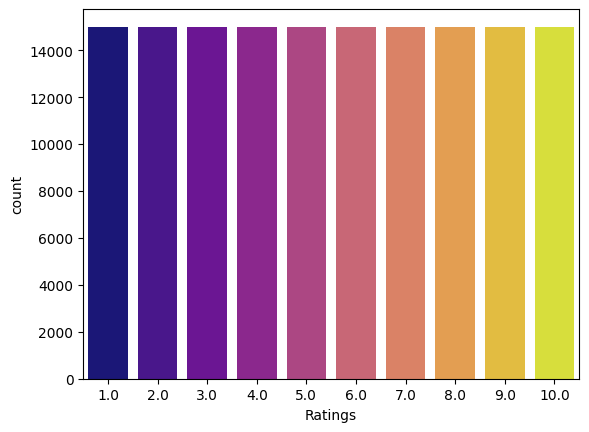

In [25]:
sns.countplot(x = df['Ratings'], hue = df['Ratings'], palette= 'plasma', legend = False)
plt.show()


### Using Word Cloud for positive and negative reviews

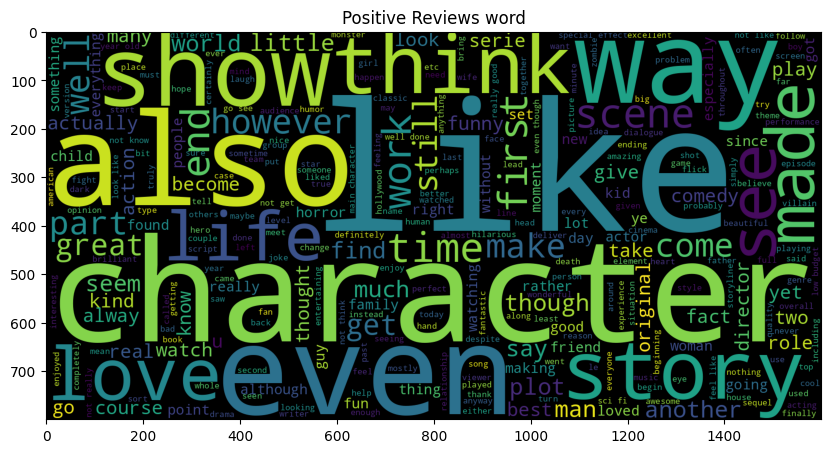

In [26]:
sentences = df['Clean_Review']

positive_rev = ' '.join(map(str, sentences[df['Ratings'] >= 7 ]))
negative_rev = ' '.join(map(str, sentences[df['Ratings'] <= 4 ]))


positve_wordcloud = WordCloud(max_words = 2000 , width = 1600 , height = 800,
                              background_color = 'black',
                              stopwords = stop_words,
                              min_font_size = 15).generate(positive_rev)

plt.figure(figsize=(10,10))
plt.imshow(positve_wordcloud)
plt.title('Positive Reviews word')
plt.show ()

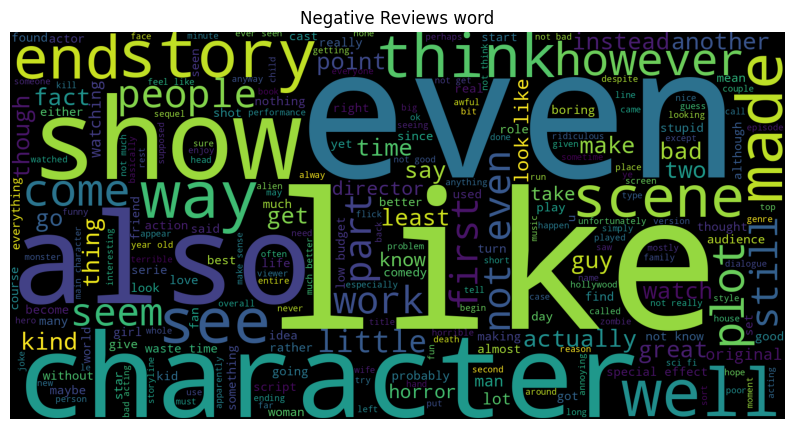

CPU times: user 49.6 s, sys: 4.35 s, total: 53.9 s
Wall time: 54.5 s


In [27]:
%%time

negative_wordcloud = WordCloud(max_words = 2000, width = 1600, height = 800,
                               background_color = 'black',
                               stopwords = stop_words,
                               min_font_size = 15).generate(negative_rev)

plt.figure(figsize = (10,10))
plt.imshow(negative_wordcloud)
plt.title('Negative Reviews word')
plt.axis('off')
plt.show()

We see most of the words are common in positve and negative wordcloud. This is one of the challenge of sentiment analysis, as same words can generate different polarities

## Statistics of Review

#### Number of characters in review
Right skewed distribution --> Many users write reviews with less characters

Text(0.5, 1.05, 'Number of characters in reviews')

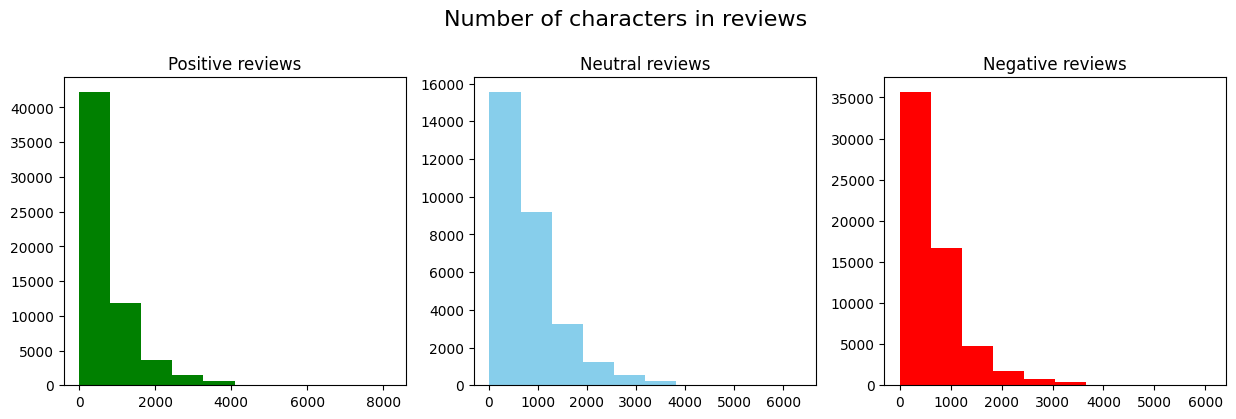

In [28]:
figure, (pos_ax, neutral_ax, neg_ax) = plt.subplots(1, 3, figsize = (15, 4))

# calculating the number of characters in each positive and negative review
len_pos_rev = df[df['Ratings'] >= 7]['Clean_Review'].str.len()
len_neg_rev = df[df['Ratings'] <= 4]['Clean_Review'].str.len()
len_neutral_rev = df[(df['Ratings'] > 4) & (df['Ratings'] < 7)]['Clean_Review'].str.len()

pos_ax.hist(len_pos_rev, color = 'green')
pos_ax.set_title('Positive reviews')

neutral_ax.hist(len_neutral_rev, color = 'skyblue')
neutral_ax.set_title('Neutral reviews')

neg_ax.hist(len_neg_rev, color = 'red')
neg_ax.set_title('Negative reviews')

figure.suptitle('Number of characters in reviews', y=1.05, fontsize=16)


### Number of words in review

`map` applies the lambda function lambda x: len(x) to each element (each list of words) in the 'Clean_Review' column after splitting.

`lambda x: len(x)` This lambda function calculates the length of each list x, which corresponds to the number of words in each 'Clean_Review' entry.

Text(0.5, 1.05, 'Number of words in reviews')

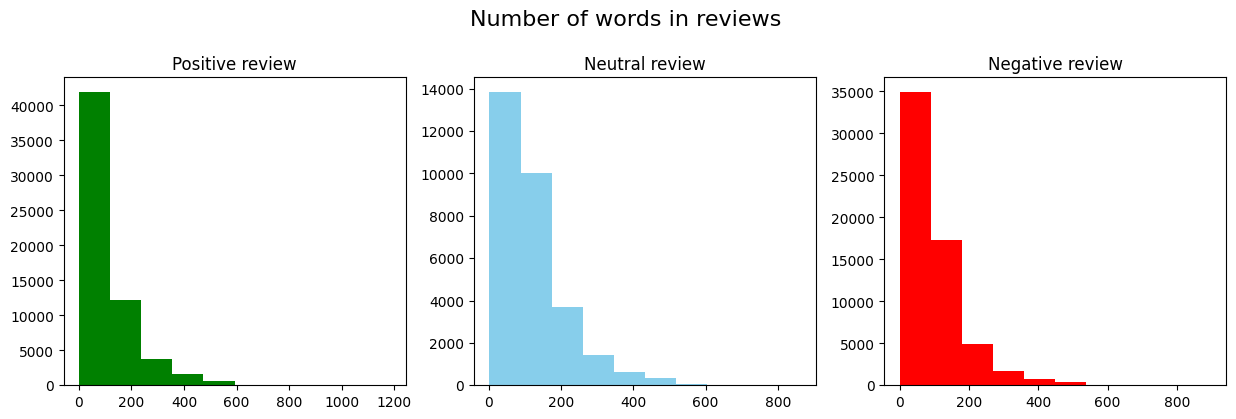

In [30]:
figure, (pos_ax, neutral_ax, neg_ax) = plt.subplots(1, 3, figsize =(15, 4))

pos_word = df[df['Ratings'] >= 7]['Clean_Review'].str.split().map(lambda x: len(x))
neutral_word =  df[(df['Ratings'] > 4) & (df['Ratings'] < 7)]['Clean_Review'].str.split().map(lambda x: len(x))
neg_word = df[df['Ratings'] <= 4]['Clean_Review'].str.split().map(lambda x: len(x))

pos_ax.hist(pos_word, color = 'green')
pos_ax.set_title('Positive review')

neutral_ax.hist(neutral_word, color = 'skyblue')
neutral_ax.set_title('Neutral review')

neg_ax.hist(neg_word, color = 'red')
neg_ax.set_title('Negative review')

figure.suptitle('Number of words in reviews', y=1.05, fontsize=16)


### Average length of words

Text(0.5, 1.05, 'Number of words in reviews')

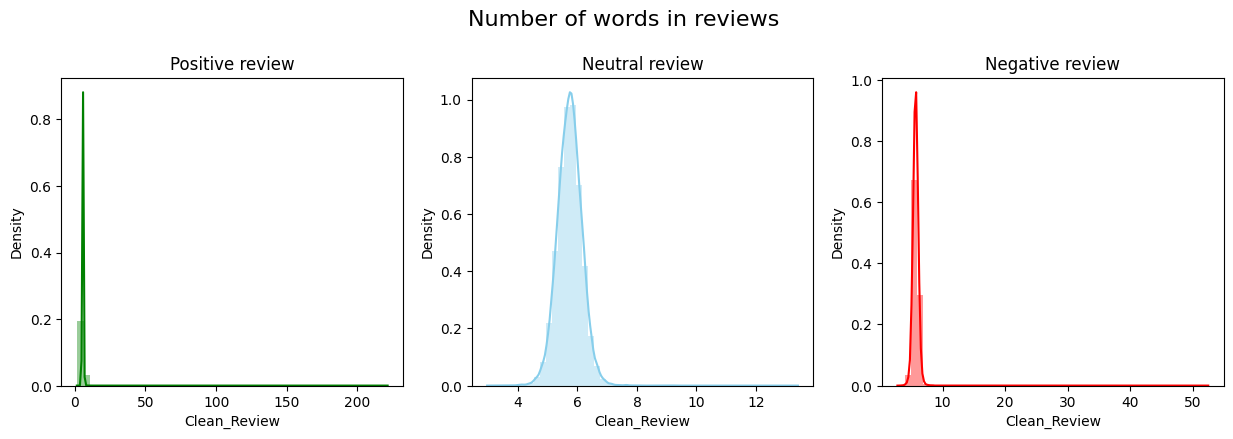

In [33]:
def average_word_length(text):
    words = text.split()
    return np.mean([len(word) for word in words])


figure, (pos_ax, neutral_ax, neg_ax) = plt.subplots(1, 3, figsize =(15, 4))

pos_word = df[df['Ratings'] >= 7]['Clean_Review'].apply(average_word_length)
neutral_word =  df[(df['Ratings'] > 4) & (df['Ratings'] < 7)]['Clean_Review'].apply(average_word_length)
neg_word = df[df['Ratings'] <= 4]['Clean_Review'].apply(average_word_length)

sns.distplot(pos_word, ax=pos_ax, color='green')
pos_ax.set_title('Positive review')

sns.distplot(neutral_word, ax=neutral_ax, color = 'skyblue')
neutral_ax.set_title('Neutral review')

sns.distplot(neg_word, ax=neg_ax, color='red')
neg_ax.set_title('Negative review')

figure.suptitle('Number of words in reviews', y=1.05, fontsize=16)

### Getting important ngrams using Tokenization and Counter



In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
from collections import Counter

def get_top_text_ngrams(corpus, n, g):
  counter = Counter()

  for text in corpus:

    tokens = text.split()
    ngrams = [' '.join(tokens[i: i + g]) for i in range(len(tokens) - g + 1)]
    counter.update(ngrams)

  return counter.most_common(n)

most_common_pos_review_bigram = get_top_text_ngrams(df.Clean_Review[df['Ratings'] >= 7], 20, 2)

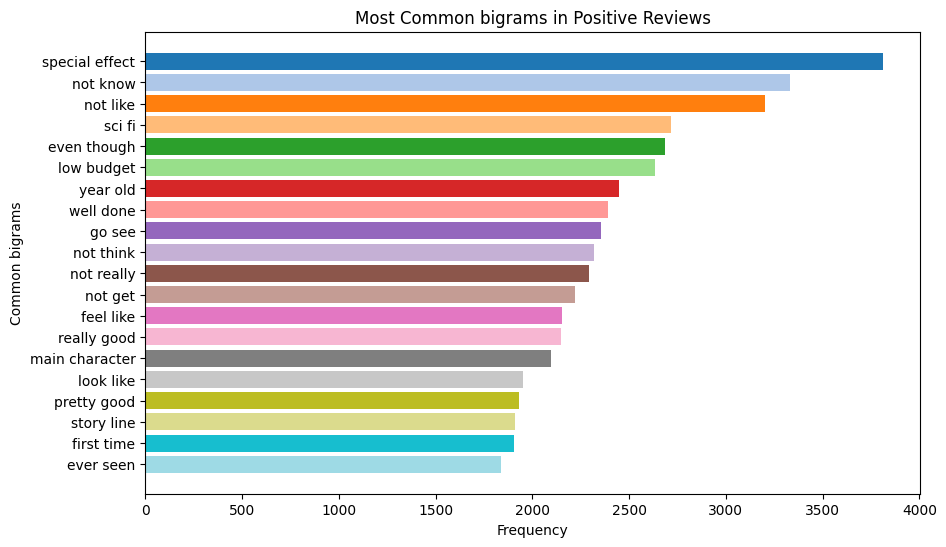

In [57]:
#creating a temporary dataframe with columns-- common words and count
temp = pd.DataFrame(most_common_pos_review_bigram, columns = ["Common_words", "Count"])

plt.figure(figsize = (10,6))
plt.barh(temp["Common_words"], temp['Count'], color=plt.cm.tab20(np.arange(len(temp))))
plt.xlabel('Frequency')
plt.ylabel('Common bigrams')
plt.title('Most Common bigrams in Positive Reviews')
plt.gca().invert_yaxis() # invert y-axis to have most common bigrams on top
plt.show()

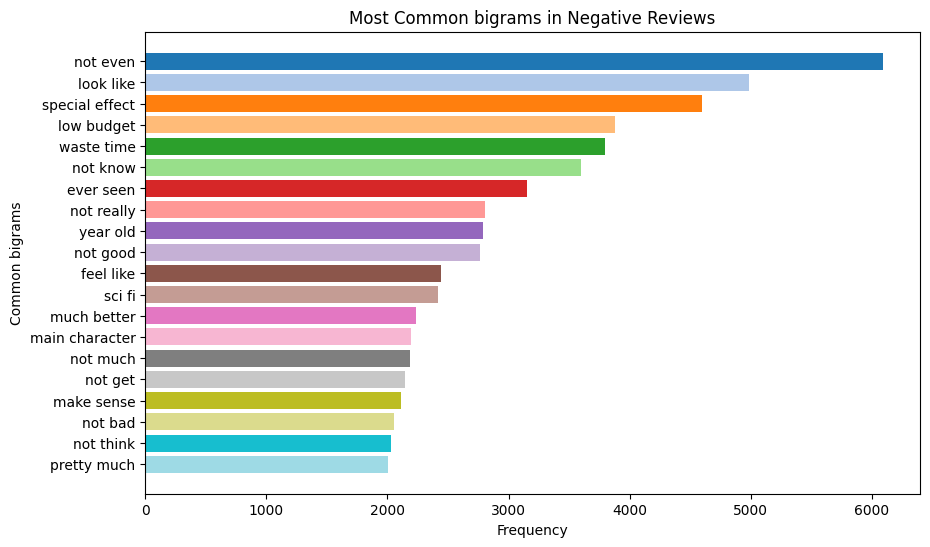

In [59]:
most_common_neg_review_bigram = get_top_text_ngrams(df.Clean_Review[df['Ratings'] <= 4], 20, 2)

temp = pd.DataFrame(most_common_neg_review_bigram, columns = ["Common_words", "Count"])

plt.figure(figsize = (10,6))
plt.barh(temp["Common_words"], temp['Count'], color=plt.cm.tab20(np.arange(len(temp))))
plt.xlabel('Frequency')
plt.ylabel('Common bigrams')
plt.title('Most Common bigrams in Negative Reviews')
plt.gca().invert_yaxis() # invert y-axis to have most common bigrams on top
plt.show()

#### Observation:

We see that the "not" word appears both in positive and negative reviews

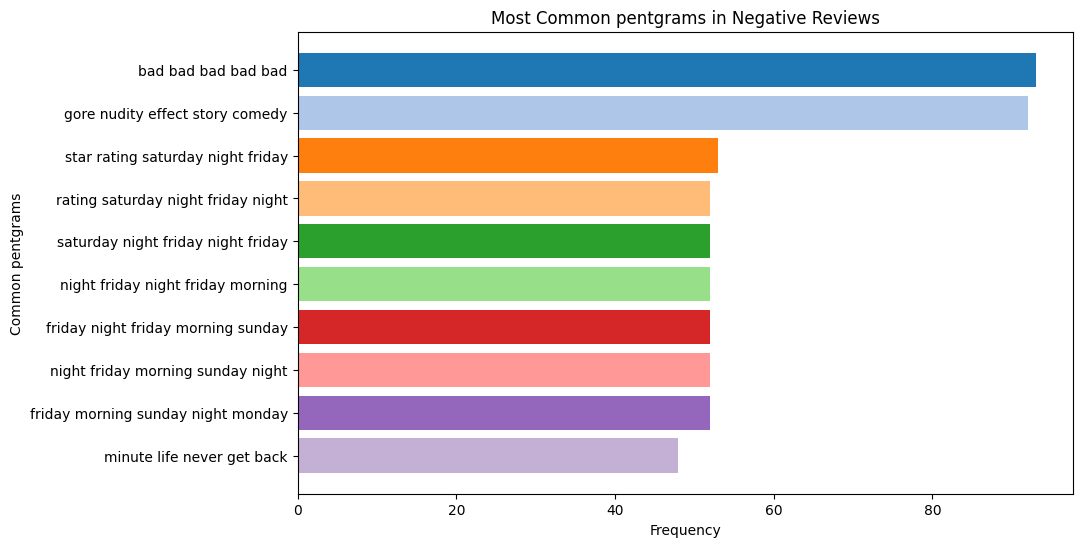

In [63]:
most_common_neg_review_pentgram = get_top_text_ngrams(df.Clean_Review[df['Ratings'] <= 4], 10, 5)

temp = pd.DataFrame(most_common_neg_review_pentgram, columns = ["Common_words", "Count"])

plt.figure(figsize = (10,6))
plt.barh(temp["Common_words"], temp['Count'], color=plt.cm.tab20(np.arange(len(temp))))
plt.xlabel('Frequency')
plt.ylabel('Common pentgrams')
plt.title('Most Common pentgrams in Negative Reviews')
plt.gca().invert_yaxis() # invert y-axis to have most common bigrams on top
plt.show()

In [67]:
## Checking the data with the word saturday in it

pd.options.display.max_colwidth = 1000
df[["Reviews","Ratings","Movies"]][(df['Ratings']<=4)&(df['Clean_Review'].str.contains("saturday night friday"))].head(5)


,Reviews,Ratings,Movies
7055,"STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning NO STARS End of Days A made for TV biopic of the pop icon Britney Spears (Natasha Bassett), from starting out with her breakthrough single Baby One More Time in 1999, where she was shoved into the limelight by her pushy mother Lynne (Nicole Oliver) and domineering manager Larry Rudolph (Peter Benson), who both naively thought she was old and mature enough to handle such massive media exposure and pushed her to lie about her virginity to keep up an illusion, through to the trials and turbulence of her relationships with Justin Timberlake (Nathan Keyes) and Kevin Federline (Clayton Chitty), before a revealing 2008 documentary aired.Sometimes, something can give you a really bad vibe, yet you still feel utterly compelled to see it. Your instinct can tell you it looks really bad, and you can see no end of bad reviews, and you can almost write a review before you've even seen it, but ...",1.0,Britney Ever After
17427,"STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday MorningWill (Joey Pollairi) is the new guy in high school, who stands out as a prime target for bullies. He soon makes friends with Jay (Zach Pearlman), Simon (Bubba Lewis) and Neil (Mark L. Young), three other social misfits who are not complete dorks but far from the coolest kids in school, either.It always spurs you on as a Brit when something home grown becomes a success, as I imagine it probably does for anyone from a small country that's not at the centre of the world (not anymore, anyway.) But it's a sad thing and a sign of the times when the only way to tell what a massive success it's been is when the Americans go and remake it. In fact, this is almost inevitable. And, inevitably, a whole lot worse.The best way I can describe The Inbetweeners USA is: imagine you've just read a really great Stephen King novel, and then see a film adaptation of it that is just like what you've rea...",2.0,The Inbetweeners
17818,"STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning The premise behind this abysmal action thriller has a group of people going for a good old bit of paint ball, only to find themselves really fighting to stay alive as a barrage of real bullets are fired at them. But the characters are never developed or explored in any way, so it's impossible to care about any of them. Needless to say, there is no air of tension or suspense whatsoever, and the acting is so bad none of them have any life anyway, as though just running around shouting and screaming incoherently at each other gives them any life. Not that there was anything special to see there anyway, just the usual generic stereotypes typical for this genre. And here we have yet another film that hasn't learned the modern trend of shaking the camera around and darkening the lens is an off putting and annoying one rather than an endearing one. One to flee all round. *",2.0,Paintball
18138,"STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning I could go to great pains to write a long, in depth review of The Last Seven, but it's hard to write much more about it other than my summary above. Right from the opening sequence, with one of the lead characters wondering around a deserted London shouting out for 'anybody!', just like in the aforementioned film, it just feels like such a pale imitation of it that it hurts. In fact, it's almost as if the director knew he was practically copying it scene for scene and just gave up bothering to tell any sort of decent story of his own. As such, it just goes through the motions of the post apocalyptic thriller genre, with the usual stereo-typical set up and characters, without firmly establishing the back story behind the majority of humanity being wiped out and making no sense. Most baffling

In [68]:
df[['Reviews','Clean_Review']].iloc[18458]

Reviews         STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning In this send up of the Taken films, the middle aged Irish hero has come down in the world from working for the CIA, and everything around him, from his ex-wife to his daughter's cherry, seems to be going away. But when some Albanian gangsters hatch a plot to put explosive devices in the local puppies, including his beloved own, he's pushed too far and swears to bring them down.If I had been a bigger fan of the Taken franchise this ultra low budget misfire is sending up, I might have been able to relate to it a little better, and enjoyed it maybe a little more, but that's a big gamble. It begs the retrospective question, if the script had such potential in the first place, why a bigger studio didn't snap it up? It pulls out all the gross out, juvenile stops it can, but I've never seen anything so unfunny in quite a while, with an incoherent, messy plot that makes it ev